# **Compte-Rendu**
# - Dimensionnement de stockage embarqué dans un tramway

## **Introduction**



In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

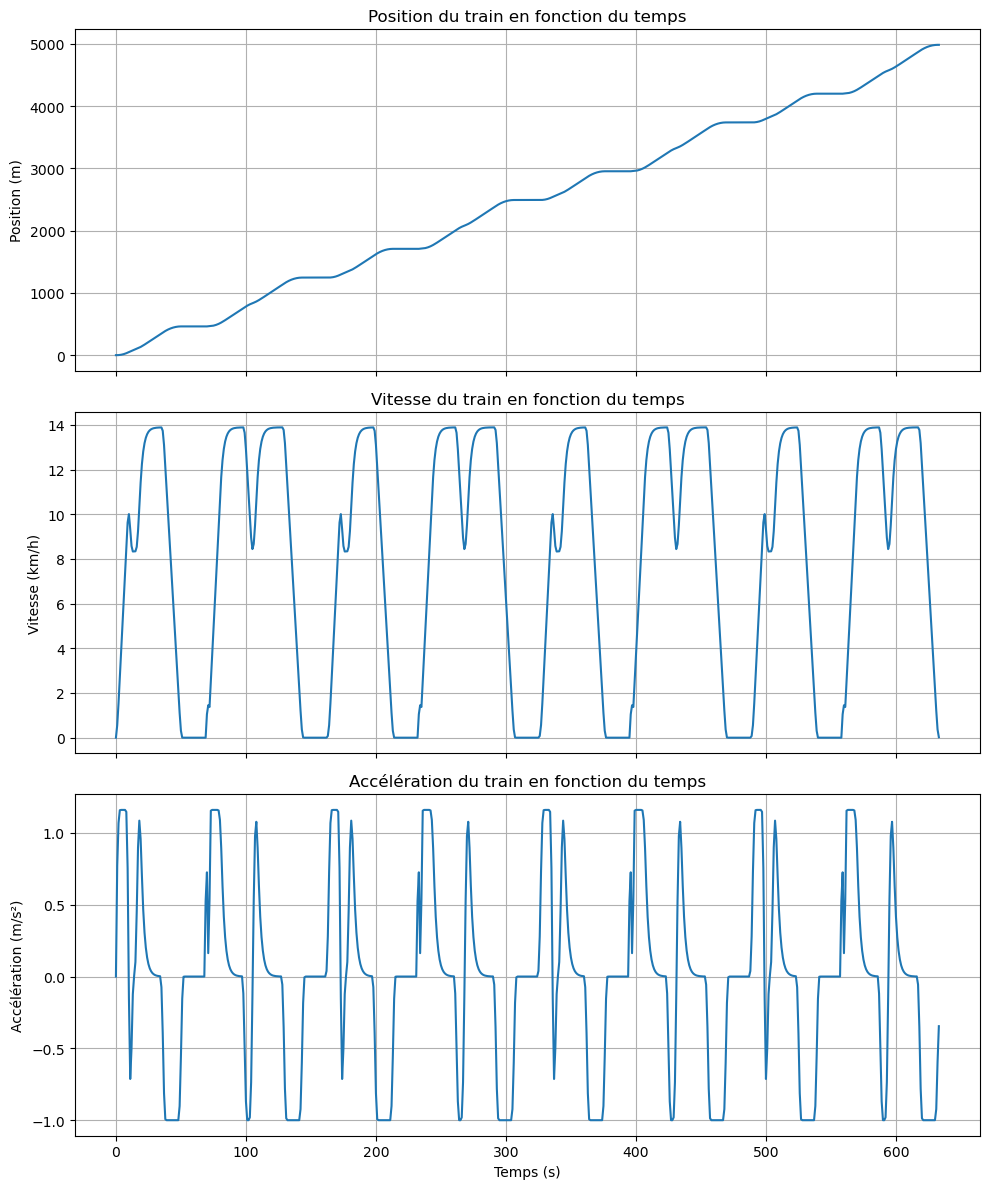

In [10]:
# Importation des modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importation des données
marche_train = pd.read_csv('marche_train.txt', delimiter='\s+', header=None)
temps_pas = marche_train[0].values # Temps (s)
position_pas = marche_train[1].values # Position (m)

# Calcul de la vitesse et de l'accélération
def gradient(x, y):
    grad = [0]
    for i in range(1, len(x)-1):
        grad_for = (y[i+1]-y[i-1])/(x[i+1]-x[i-1])
        grad.append(grad_for)
    grad.append((y[-1]-y[-2])/(x[-1]-x[-2]))
    return grad

vitesse = gradient(temps_pas, position_pas) # Vitesse (m/s)
acceleration = gradient(temps_pas, vitesse) # Accélération (m/s²)

# Création des sous-graphiques et ajustement de l'axe x
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Tracé de la position
axs[0].plot(temps_pas, position_pas)
axs[0].set_title('Position du train en fonction du temps')
axs[0].set_ylabel('Position (m)')
axs[0].grid()

# Tracé de la vitesse
axs[1].plot(temps_pas, vitesse)
axs[1].set_title('Vitesse du train en fonction du temps')
axs[1].set_ylabel('Vitesse (km/h)')
axs[1].grid()

# Tracé de l'accélération
axs[2].plot(temps_pas, acceleration)
axs[2].set_title("Accélération du train en fonction du temps")
axs[2].set_xlabel('Temps (s)')
axs[2].set_ylabel('Accélération (m/s²)')
axs[2].grid()

# Uniformisation de l'axe x et extension de sa longueur
plt.tight_layout()
plt.show()

##  Le système simulé sans batterie

In [13]:
# Paramètres
## Train
Masse = 70 # tonne
acc_gravite = 9.81 # m/s^2
alpha = 0
coef_efficacite = 0.8
P_train_min = 35e3

## Constantes
A0 = 780 # N
A1 = 6.4 # N/tonne
B0 = 0
B1 = 0.14 # N/tonne/(km * h^-1)
C0 = 0.3634 # N/(km * h^-1)^2
C1 = 0

## Electrique
V_sst = 790 # Volts
R_sst = 33e-3 # Ohm
Rho_lac = 131e-6 # Ohm/m
Rho_rail = 18e-6 # Ohm/m

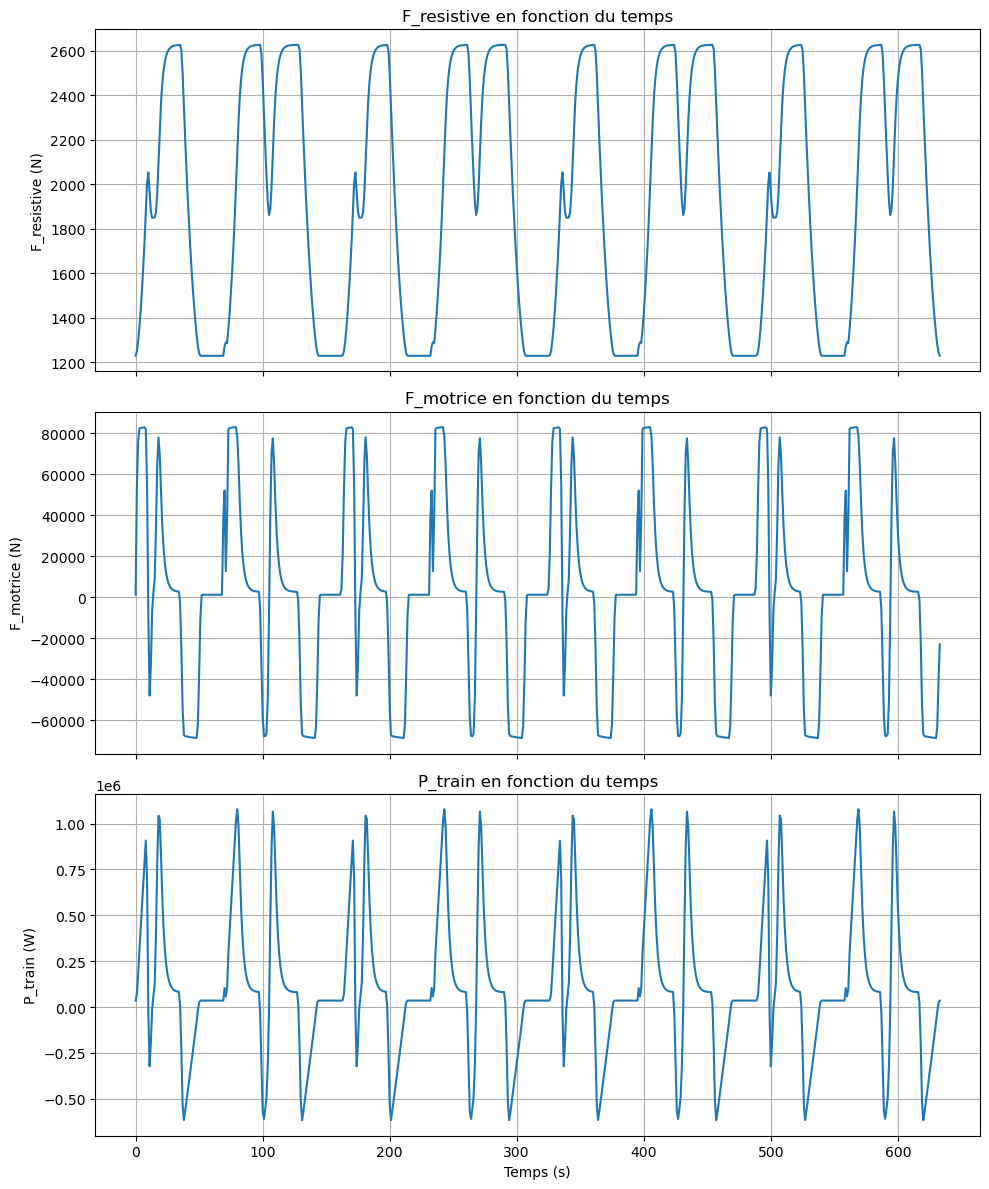

In [15]:
# Calcul de la partie mecanique
def calcul_force(vitesse, acceleration):
  F_resistive = []
  F_motrice = []
  P_train = []

  for i in range(len(vitesse)):
    # Force resistive
    F_resistive_for = (A0 + A1 * Masse) + (B0 + B1 * Masse) * vitesse[i] * 3.6 + (C0 + C1 * Masse) * (vitesse[i] * 3.6)**2
    F_resistive.append(F_resistive_for)

    # Force motrice
    F_motrice_for = Masse*10**3 * acceleration[i] + Masse*10**3 * acc_gravite * np.sin(alpha) + F_resistive_for
    F_motrice.append(F_motrice_for)

    # Puissance mecanique(/train)
    P_mecanique = F_motrice_for * vitesse[i]
    if P_mecanique < 0:
      P_mecanique = P_mecanique * coef_efficacite + P_train_min
    else:
      P_mecanique = P_mecanique / coef_efficacite + P_train_min
    P_train.append(P_mecanique)

  return F_resistive, F_motrice, P_train

F_resistive, F_motrice, P_train = calcul_force(vitesse, acceleration)

# Création des sous-graphiques et ajustement de l'axe x
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Tracé de la position
axs[0].plot(temps_pas, F_resistive)
axs[0].set_title('F_resistive en fonction du temps')
axs[0].set_ylabel('F_resistive (N)')
axs[0].grid()

# Tracé de la vitesse
axs[1].plot(temps_pas, F_motrice)
axs[1].set_title('F_motrice en fonction du temps')
axs[1].set_ylabel('F_motrice (N)')
axs[1].grid()

# Tracé de l'accélération
axs[2].plot(temps_pas, P_train)
axs[2].set_title("P_train en fonction du temps")
axs[2].set_xlabel('Temps (s)')
axs[2].set_ylabel('P_train (W)')
axs[2].grid()

# Uniformisation de l'axe x et extension de sa longueur
plt.tight_layout()
plt.show()

Avertissement : À la position 1367.424415588376, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 1378.33865356445, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 1740.186767578122, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 1749.089660644528, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 1759.152770996091, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 1770.360168457028, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 2098.084411621091, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 2108.1391601562473, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 2119.3386230468723, la puissance demandée dépasse la capacité d'alimentation.
Avertissement : À la position 2516.1

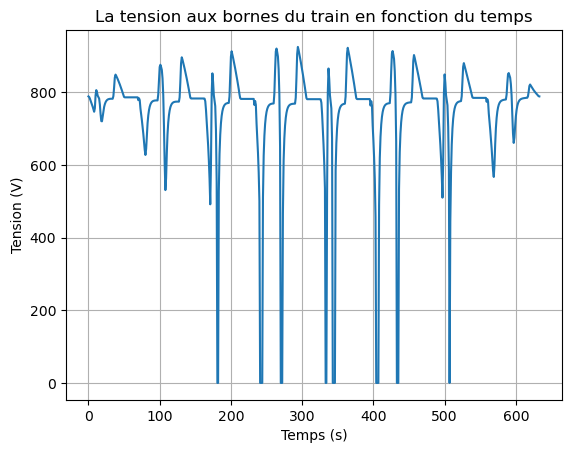

In [17]:
def calcul_tension(position_pas, V_sst, R_sst, Rho_lac, Rho_rail, P_train):
    """
    Calcul de la tension aux bornes du train en fonction de la position et de la puissance demandée.
    """
    R_eq = []
    V_train = []
    x_tot = position_pas[-1]

    for i in range(len(position_pas)):
      # Calcul de la distance entre le train et les sous-stations
      x_1 = position_pas[i]
      x_2 = x_tot - x_1

      # Calcul de la résistance équivalente
      R_eq_1 = R_sst + Rho_lac * x_1 + Rho_rail * x_1
      R_eq_2 = R_sst + Rho_lac * x_2 + Rho_rail * x_2
      R_eq_for = R_eq_1 * R_eq_2 / (R_eq_1 + R_eq_2)
      R_eq.append(R_eq_for)

      # Calcul de la tension aux bornes du train
      Delta = V_sst**2 - 4 * P_train[i] * R_eq_for
      if Delta < 0:
        print(f"Avertissement : À la position {position_pas[i]}, la puissance demandée dépasse la capacité d'alimentation.")
        V_train_for = 0  # ou définir la tension maximale possible selon les besoins
      else:
        V_train_for = (V_sst + np.sqrt(Delta)) / 2
      V_train.append(V_train_for)

    return R_eq, V_train

# Appel de la fonction avec les paramètres donnés
R_eq, V_train = calcul_tension(position_pas, V_sst, R_sst, Rho_lac, Rho_rail, P_train)

# Visualisation des résultats
plt.plot(temps_pas, V_train)
plt.title('La tension aux bornes du train en fonction du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.grid()
plt.show()


## Le système simulé avec batterie

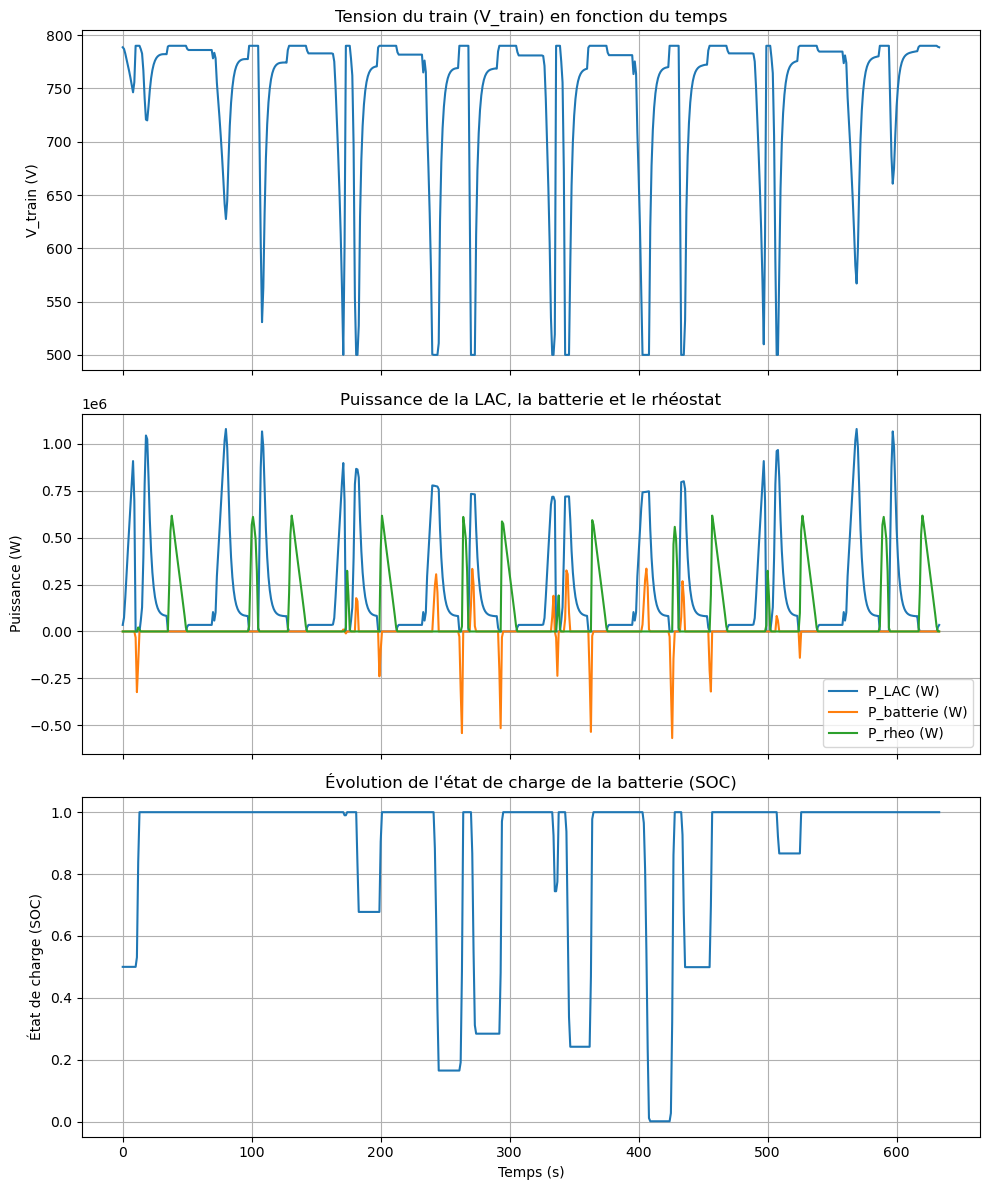

In [20]:
# Définition des paramètres
capacite_batterie = 0.292e3  # Capacité de la batterie (Wh)
charge_initial = 0.5 * capacite_batterie  # État de charge initial de la batterie (50%)
V_safe = 500 #V

def mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie):
    P_bat = P_train[i] - P_LAC_for
    delta_t = temps_pas[i] - temps_pas[i-1]
    delta_charge = P_bat * delta_t / 3600
    charge_new = charge_Batterie[-1] - delta_charge

    P_res = 0

    if charge_new > capacite_batterie:
      P_res = (charge_new - capacite_batterie) * 3600 / delta_t
      P_bat += P_res
      charge_new = capacite_batterie

    elif charge_new < 0:
      P_res = -charge_new * 3600 / delta_t
      charge_new = 0

    charge_Batterie.append(charge_new)
    return P_bat, charge_Batterie, P_res


def calcul_tension_avec_batterie(position_pas, V_sst, V_safe, R_sst, Rho_lac, Rho_rail, P_train, temps_pas, capacite_batterie, charge_initial):
    # Initialisation de l'état de charge de la batterie
    R_eq = []
    V_train = []
    P_LAC = []
    P_batterie = []
    P_rheo = []
    charge_Batterie = [charge_initial]

    x_tot = position_pas[-1]

    for i in range(len(position_pas)):
        # Calcul de la distance entre le train et les sous-stations
        x_1 = position_pas[i]
        x_2 = x_tot - x_1

        # Calcul de la résistance équivalente des lignes
        R_eq_1 = R_sst + Rho_lac * x_1 + Rho_rail * x_1
        R_eq_2 = R_sst + Rho_lac * x_2 + Rho_rail * x_2
        R_eq_for = R_eq_1 * R_eq_2 / (R_eq_1 + R_eq_2)
        R_eq.append(R_eq_for)

        # Calcul du discriminant pour déterminer la puissance disponible
        Delta = V_sst**2 - 4 * P_train[i] * R_eq_for

        # Cas où le train consomme de l'énergie
        if P_train[i] > 0:

          # Le réseau peut fournir la puissance demandée
          if Delta > 0:

              V_train_for = (V_sst + np.sqrt(Delta)) / 2

              # V_train_for >= V_safe
              if V_train_for >= V_safe:
                V_train_for = V_train_for
                P_LAC_for = P_train[i]

                # Mise à jour du SOC pour la décharge de la batterie
                P_bat, charge_Batterie, P_res = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

              # V_train_for < V_safe
              else:
                V_train_for = V_safe
                P_LAC_for = (V_sst - V_safe) * V_train_for / R_eq_for # Puissance maximale fournie par la LAC

                # Mise à jour du SOC pour la décharge de la batterie
                P_bat, charge_Batterie, P_res = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

          # Le réseau ne peut pas fournir la puissance demandée
          else:
              V_train_for = V_safe
              P_LAC_for = (V_sst - V_safe) * V_train_for / R_eq_for # Puissance maximale fournie par la LAC

              # Mise à jour du SOC pour la décharge de la batterie
              P_bat, charge_Batterie, P_res = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

        elif P_train[i] == 0:
          V_train_for = V_sst
          P_LAC_for = 0

          # Mise à jour du SOC pour la décharge de la batterie
          P_bat, charge_Batterie, P_res = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

        # Cas où le train est en freinage (P_train < 0)
        else:
          V_train_for = V_sst  # Tension d'alimentation pendant le freinage
          P_LAC_for = 0  # Pas de consommation du réseau pendant le freinage

          # Mise à jour du SOC pour la décharge de la batterie
          P_bat, charge_Batterie, P_res = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

        # Stocker les valeurs
        V_train.append(V_train_for)
        P_LAC.append(P_LAC_for)
        P_batterie.append(P_bat)
        P_rheo.append(P_res)

    return R_eq, V_train, P_LAC, P_batterie, charge_Batterie, P_rheo


# Calculer les résultats
R_eq, V_train, P_LAC, P_batterie, charge_Batterie, P_rheo = calcul_tension_avec_batterie(
    position_pas, V_sst, V_safe, R_sst, Rho_lac, Rho_rail, P_train, temps_pas, capacite_batterie, charge_initial
)

# Visualisation de la tension aux bornes du train
# Création des sous-graphiques et ajustement de l'axe x
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Tracé de la tension V_train
axs[0].plot(temps_pas, V_train)
axs[0].set_title("Tension du train (V_train) en fonction du temps")
axs[0].set_ylabel("V_train (V)")
axs[0].grid()

# Tracé de la puissance P_LAC, P_batterie et P_rheo
axs[1].plot(temps_pas, P_LAC, label="P_LAC (W)")
axs[1].plot(temps_pas, P_batterie, label="P_batterie (W)")
axs[1].plot(temps_pas, P_rheo, label="P_rheo (W)")
axs[1].set_title("Puissance de la LAC, la batterie et le rhéostat")
axs[1].set_ylabel("Puissance (W)")
axs[1].legend()
axs[1].grid()

# Tracé de l'état de charge de la batterie (SOC)
SOC = np.array(charge_Batterie) / capacite_batterie  # Normalisation pour obtenir le SOC en pourcentage
axs[2].plot(temps_pas, SOC[:-1])
axs[2].set_title("Évolution de l'état de charge de la batterie (SOC)")
axs[2].set_xlabel("Temps (s)")
axs[2].set_ylabel("État de charge (SOC)")
axs[2].grid()

# Uniformisation de l'axe x et extension de sa longueur
plt.tight_layout()
plt.show()



## Monte carlo

In [23]:
def mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie):
    """
    Mise à jour de l'état de charge (SOC) de la batterie.
    """
    P_bat = P_train[i] - P_LAC_for
    delta_t = temps_pas[i] - temps_pas[i-1]
    # Convertir la puissance en variation de charge (Wh) sur le pas de temps
    delta_charge = P_bat * delta_t / 3600
    charge_new = charge_Batterie[-1] - delta_charge

    P_res = 0

    # Cas où la batterie dépasse sa capacité maximale
    if charge_new > capacite_batterie:
        # L'énergie excédentaire est rejetée (frein rhéostatique ou dissipation)
        P_res = (charge_new - capacite_batterie) * 3600 / delta_t
        P_bat += P_res
        charge_new = capacite_batterie

    # Cas où la batterie est entièrement déchargée
    elif charge_new < 0:
        # Renvoie False pour indiquer l'impossibilité de poursuivre (batterie vide)
        return False, charge_Batterie, P_res

    charge_Batterie.append(charge_new)
    return P_bat, charge_Batterie, P_res


def calcul_SOC_seule(position_pas, V_sst, V_safe, R_sst, Rho_lac, Rho_rail,
                     P_train, temps_pas, capacite_batterie, charge_initial):
    """
    Calcul simplifié du SOC de la batterie en considérant uniquement les transitions
    entre la puissance fournie par la LAC et la puissance demandée par le train.
    Retourne True si le SOC reste dans les limites [0, capacite_batterie] pour tout le parcours,
    ou False si la batterie tombe à 0 (impossibilité de poursuivre).
    """
    # Initialisation de l'état de charge de la batterie
    R_eq = []
    V_train = []
    P_LAC = []
    P_batterie = []
    P_rheo = []
    charge_Batterie = [charge_initial]

    x_tot = position_pas[-1]

    for i in range(len(position_pas)):
        # Calcul de la distance aux sous-stations
        x_1 = position_pas[i]
        x_2 = x_tot - x_1

        # Calcul de la résistance équivalente
        R_eq_1 = R_sst + Rho_lac * x_1 + Rho_rail * x_1
        R_eq_2 = R_sst + Rho_lac * x_2 + Rho_rail * x_2
        R_eq_for = R_eq_1 * R_eq_2 / (R_eq_1 + R_eq_2)
        R_eq.append(R_eq_for)

        # Discriminant pour évaluer la capacité de la LAC à fournir la puissance demandée
        Delta = V_sst**2 - 4 * P_train[i] * R_eq_for

        # Cas où le train consomme de l'énergie (P_train > 0)
        if P_train[i] > 0:
            # Le réseau peut fournir la puissance
            if Delta > 0:
                V_train_for = (V_sst + np.sqrt(Delta)) / 2

                # Vérifier le seuil V_safe
                if V_train_for >= V_safe:
                    P_LAC_for = P_train[i]
                    result = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)
                else:
                    # Tension limitée par V_safe
                    V_train_for = V_safe
                    P_LAC_for = (V_sst - V_safe) * V_train_for / R_eq_for
                    result = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

            # Le réseau ne peut pas fournir la puissance demandée
            else:
                V_train_for = V_safe
                P_LAC_for = (V_sst - V_safe) * V_train_for / R_eq_for
                result = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

        # Cas où le train ne consomme ni ne fournit (P_train = 0)
        elif P_train[i] == 0:
            V_train_for = V_sst
            P_LAC_for = 0
            result = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

        # Cas où le train est en freinage (P_train < 0)
        else:
            # Le train injecte de l'énergie (récupération)
            V_train_for = V_sst
            P_LAC_for = 0
            result = mise_a_jour_SOC(charge_Batterie, P_train, P_LAC_for, temps_pas, i, capacite_batterie)

        # Vérifier si la batterie est vide
        if result[0] is False:
            return False

    return True


def pareto_frontier(points):
    """
    Détermine l'ensemble Pareto d'un ensemble de points 2D.
    Chaque point est comparé afin d'identifier les points non dominés.
    """
    pareto_front = []
    for i, point1 in enumerate(points):
        dominated = False
        for j, point2 in enumerate(points):
            if i != j:
                # Si point2 domine point1, alors point1 est éliminé
                if (point2[0] <= point1[0] and point2[1] <= point1[1]):
                    dominated = True
                    break
        if not dominated:
            pareto_front.append(point1)
    return pareto_front


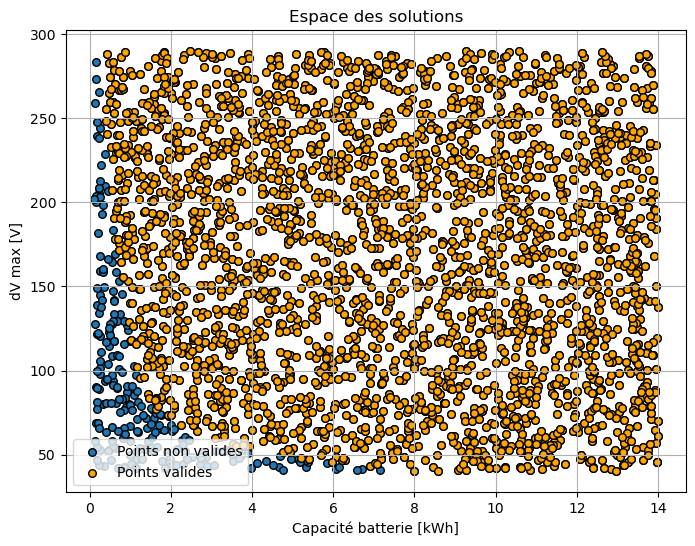

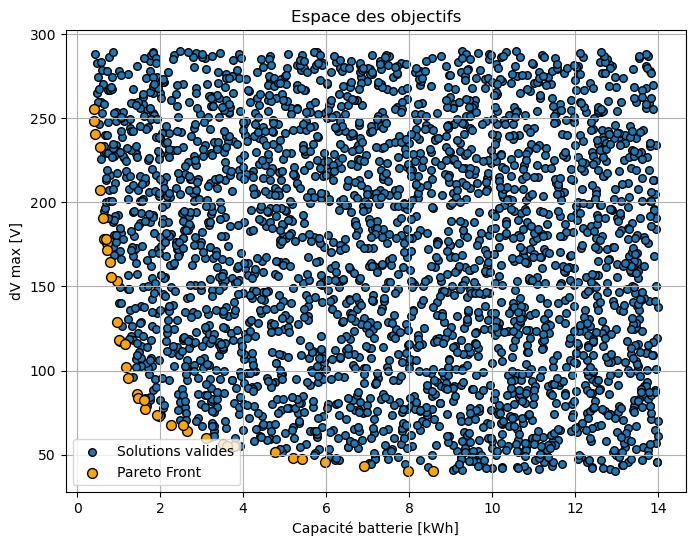

In [25]:
# Population
population_size = 3000
population = []

for i in range(population_size):
    # Définition de l'espace de recherche
    V_safe = np.random.uniform(500, 750)
    C_bat = np.random.uniform(0.1e3, 14e3)
    individual = [C_bat, V_safe]
    population.append(individual)

# Parcourir tous les points pour filtrer ceux qui satisfont la contrainte SOC
valid_points = []
for i in range(len(population)):
    V_safe = population[i][1]
    capacite_batterie = population[i][0]

    # Vérification de la capacité de la batterie à satisfaire les besoins
    result = calcul_SOC_seule(
        position_pas, V_sst, V_safe, R_sst, Rho_lac, Rho_rail,
        P_train, temps_pas, capacite_batterie, charge_initial=0.5 * capacite_batterie
    )

    if result:  # Si la batterie répond aux exigences, on enregistre ce point
        # Conversion en kWh et calcul de dV = (790 - V_safe)
        valid_points.append((capacite_batterie / 1e3, 790 - V_safe))

# Calcul du front de Pareto
pareto_points = pareto_frontier(valid_points)

# Extraction des valeurs C_bat et dV sur le front de Pareto
pareto_c = [p[0] for p in pareto_points]
pareto_dV = [p[1] for p in pareto_points]

# Récupération des données pour toutes les solutions (afin d'afficher l'espace)
C_bat = [ind[0] / 1e3 for ind in population]
dV_safe = [790 - ind[1] for ind in population]

# Premier graphique : toutes les solutions et les solutions valides
plt.figure(figsize=(8, 6))
plt.scatter(C_bat, dV_safe, edgecolors='k', s=30, label="Points non valides")
plt.scatter([p[0] for p in valid_points],
            [p[1] for p in valid_points],
            edgecolors='k', s=30, color='orange', label="Points valides")
plt.title("Espace des solutions")
plt.xlabel("Capacité batterie [kWh]")
plt.ylabel("dV max [V]")
plt.grid(True)
plt.legend()
plt.show()

# Deuxième graphique : solutions valides et front de Pareto
plt.figure(figsize=(8, 6))
plt.scatter([p[0] for p in valid_points],
            [p[1] for p in valid_points],
            edgecolors='k', s=30, label="Solutions valides")
plt.scatter(pareto_c, pareto_dV, color='orange', edgecolors='k', s=50, label="Pareto Front")
plt.title("Espace des objectifs")
plt.xlabel("Capacité batterie [kWh]")
plt.ylabel("dV max [V]")
plt.grid(True)
plt.legend()
plt.show()


Dans le premier graphique représentant l'espace des solutions, les points marqués en bleu correspondent aux solutions non valides. Ces solutions sont caractérisées par une capacité de batterie insuffisante pour répondre aux besoins énergétiques du train lorsque l'alimentation des sous-stations (SST) est coupée.

Dans le deuxième graphique, seules les solutions valides sont conservées et affichées. Parmi celles-ci, le Front de Pareto est mis en évidence en orange. Ce front représente l'ensemble des solutions optimales non dominées, c'est-à-dire les compromis les plus performants entre la minimisation de la capacité de la batterie et la minimisation de la chute de tension.



## NSGAII


=== Génération 1 ===
   Nombre total d'individus : 100
   Front #1 size: 6


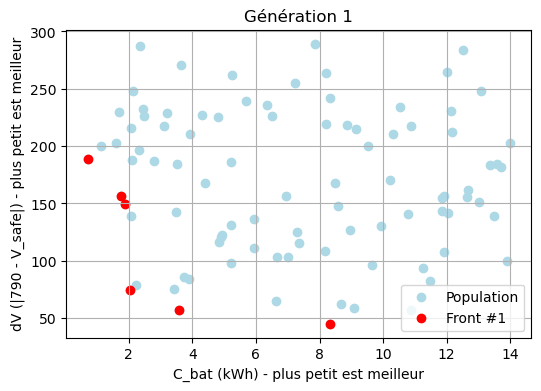


=== Génération 2 ===
   Nombre total d'individus : 100
   Front #1 size: 8


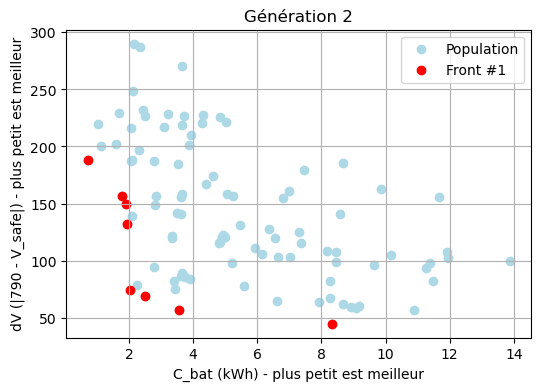


=== Génération 3 ===
   Nombre total d'individus : 100
   Front #1 size: 8


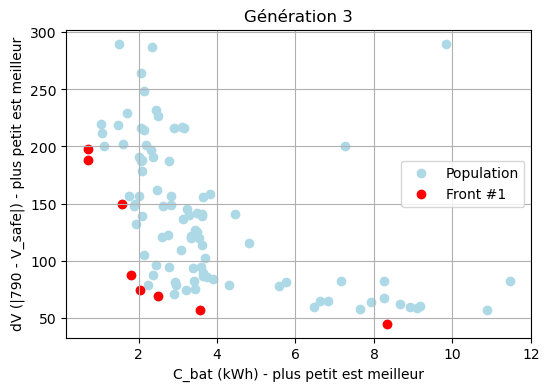


=== Génération 4 ===
   Nombre total d'individus : 100
   Front #1 size: 11


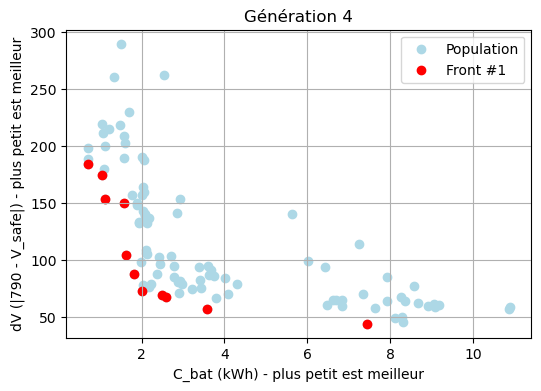


=== Génération 5 ===
   Nombre total d'individus : 100
   Front #1 size: 13


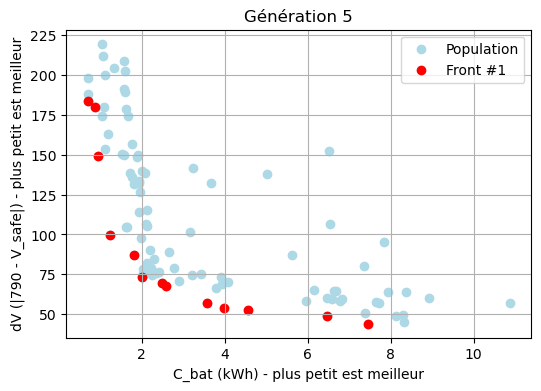


=== Génération 6 ===
   Nombre total d'individus : 100
   Front #1 size: 17


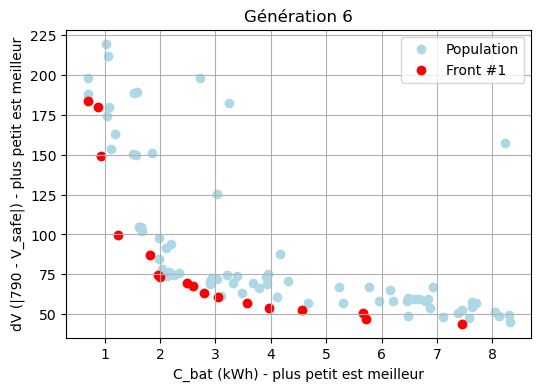


=== Génération 7 ===
   Nombre total d'individus : 100
   Front #1 size: 20


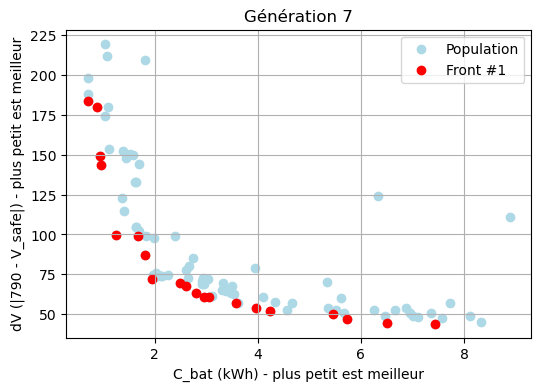


=== Fin de l'algorithme ===
   Taille du front 1 final: 20


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1) Définition du problème
# ======================
V_SST = 790.0  # Tension nominale du réseau
POP_SIZE = 100  # Taille de la population
NB_GENERATIONS = 7  # Nombre de générations
PARENT_RATIO = 0.5  # Proportion de la population à conserver (sélection)
ALPHA_MIN, ALPHA_MAX = -0.1, 1.1

# Espace de décision pour chaque individu: [C_bat, V_safe]
#  - C_bat (Wh) : [100, 14000]
#  - V_safe (V) : [500, 750]

def init_population(pop_size=POP_SIZE):
    """Tirage aléatoire d'une population initiale dans l'espace de recherche."""
    population = []
    for _ in range(pop_size):
        C_bat = np.random.uniform(0.1e3, 14e3)  # en Wh
        V_safe = np.random.uniform(500, 750)   # en V
        population.append([C_bat, V_safe])
    return population

def evaluate_individual(individual):
    """
    Évalue l'individu sur les deux objectifs à minimiser:
      1) C_bat (kWh) => plus c'est petit mieux c'est
      2) dV = |V_SST - V_safe| => plus c'est petit mieux c'est
    On suppose que la contrainte "SOC ne doit pas tomber à zéro"
    est testée par calcul_SOC_seule(). Si contrainte violée, on renvoie (inf, inf).
    """
    C_bat, V_safe = individual
    # Appel de ta fonction de vérification du SOC
    is_feasible = calcul_SOC_seule(
        position_pas,
        V_SST,
        V_safe,
        R_sst,
        Rho_lac,
        Rho_rail,
        P_train,
        temps_pas,
        C_bat,
        charge_initial=0.5 * C_bat
    )
    if not is_feasible:
        return (float('inf'), float('inf'))
    else:
        # Conversion en kWh
        c_kwh = C_bat / 1e3
        dV = abs(V_SST - V_safe)
        return (c_kwh, dV)

def dominates(objA, objB):
    """
    Vérifie si A domine B pour un problème bi-objectif en minimisation.
    A domine B si:
      A1 <= B1, A2 <= B2,
      et (A1 < B1 ou A2 < B2).
    """
    return (objA[0] <= objB[0] and objA[1] <= objB[1]
            and (objA[0] < objB[0] or objA[1] < objB[1]))

def fast_nondominated_sort(population, objectives):
    """
    Effectue un tri non-dominé simple.
    population : liste d'individus
    objectives : liste de tuples (obj1, obj2) déjà calculés, même longueur que population
    Retourne une liste de "fronts", chaque front est une liste d'indices.
      front[0] = indices du rang 1
      front[1] = indices du rang 2
      etc.
    """
    pop_size = len(population)
    S = [[] for _ in range(pop_size)]  # pour chaque i, l'ensemble des individus qu'il domine
    n = [0]*pop_size  # pour chaque i, combien d'individus le dominent
    rank = [0]*pop_size

    # 1) Construire S[i], n[i] pour tous les individus
    for i in range(pop_size):
        obj_i = objectives[i]
        for j in range(pop_size):
            if i == j:
                continue
            obj_j = objectives[j]
            if dominates(obj_i, obj_j):
                S[i].append(j)
            elif dominates(obj_j, obj_i):
                n[i] += 1

    # 2) Trouver le rang 1
    front = [[]]
    for i in range(pop_size):
        if n[i] == 0:
            rank[i] = 1
            front[0].append(i)

    # 3) Trouver rang 2, rang 3, ...
    f = 0
    while front[f]:
        Q = []
        for i in front[f]:
            for j in S[i]:
                n[j] -= 1
                if n[j] == 0:
                    rank[j] = f + 2
                    Q.append(j)
        f += 1
        front.append(Q)
    # front[-1] sera vide normalement, on去掉
    if not front[-1]:
        front.pop()
    return front

def selection_by_front(population, objectives, front, max_keep):
    """
    On parcourt les fronts dans l'ordre (rang 1, rang 2, ...)
    et on ajoute les individus jusqu'à atteindre max_keep.
    Pas de critère de distance dans ce code (simplifié).
    """
    new_pop = []
    used = 0
    for f in front:
        if used + len(f) <= max_keep:
            # prendre tout ce front
            new_pop.extend(f)
            used += len(f)
        else:
            # s'il reste de la place mais pas assez pour tout le front,
            # on peut soit:
            #   - prendre partiellement (aléatoirement)
            #   - ou prendre tout (dans un vrai NSGA-II, on ferait crowding distance).
            # Ici on va simplement prendre partiellement au hasard:
            needed = max_keep - used
            chosen = np.random.choice(f, needed, replace=False)
            new_pop.extend(chosen)
            used += needed
            break
        if used >= max_keep:
            break
    return new_pop

def crossover(parent1, parent2):
    """
    Croisement linéaire avec alpha ~ U(-0.1,1.1) pour chaque gène.
    Pas de mutation ici, comme conseillé par le prof.
    """
    alpha1 = np.random.uniform(ALPHA_MIN, ALPHA_MAX)
    alpha2 = np.random.uniform(ALPHA_MIN, ALPHA_MAX)

    # gène 1 (C_bat)
    c_bat = alpha1 * parent1[0] + (1 - alpha1) * parent2[0]
    # gène 2 (V_safe)
    v_safe = alpha2 * parent1[1] + (1 - alpha2) * parent2[1]

    # Contrôle des bornes
    c_bat = np.clip(c_bat, 0.1e3, 14e3)
    v_safe = np.clip(v_safe, 500, 750)
    return [c_bat, v_safe]

def reproduction(selected_indices, population):
    """
    Génération de nouveaux individus par croisement.
    On prend les indices sélectionnés, et on génère
    autant de nouveaux enfants que nécessaires pour retrouver la taille initiale.
    """
    new_pop = []
    # Mélanger un peu pour croiser
    np.random.shuffle(selected_indices)
    nb_selected = len(selected_indices)
    # Tant qu'on n'atteint pas POP_SIZE, on croise
    while len(new_pop) < POP_SIZE - nb_selected:
        # Choix aléatoire de 2 parents
        p1, p2 = np.random.choice(selected_indices, 2, replace=False)
        child = crossover(population[p1], population[p2])
        new_pop.append(child)
    return new_pop

# ======================
# 2) Boucle principale
# ======================

def main():
    population = init_population(POP_SIZE)

    for gen in range(NB_GENERATIONS):
        # 2.1) Évaluation
        objectives_list = [evaluate_individual(ind) for ind in population]

        # 2.2) Non-dominated sort => fronts
        fronts = fast_nondominated_sort(population, objectives_list)

        # 2.3) Sélection : on conserve 50% (par exemple)
        #     (ou n'importe quel ratio, ici on vise "max_keep=POP_SIZE*PARENT_RATIO")
        max_keep = int(POP_SIZE * PARENT_RATIO)
        best_indices = selection_by_front(population, objectives_list, fronts, max_keep)

        # On extrait population "parents"
        parents = [population[i] for i in best_indices]

        # 2.4) Création de nouveaux individus (croisement)
        children = reproduction(best_indices, population)

        # 2.5) Mise à jour de la population : parents + enfants
        population = parents + children

        # Affichage de l'avancement
        print(f"\n=== Génération {gen+1} ===")
        print(f"   Nombre total d'individus : {len(population)}")
        print(f"   Front #1 size: {len(fronts[0])}")

        # [Optionnel] Visualisation du front #1
        # Récupérons juste le front 1 pour tracer
        front1_objs = [objectives_list[i] for i in fronts[0]]
        c_vals = [o[0] for o in front1_objs]
        dv_vals = [o[1] for o in front1_objs]

        plt.figure(figsize=(6,4))
        plt.scatter([obj[0] for obj in objectives_list if obj[0] != float('inf')],
                    [obj[1] for obj in objectives_list if obj[1] != float('inf')],
                    color='lightblue', label='Population')
        plt.scatter(c_vals, dv_vals, color='red', label='Front #1')
        plt.xlabel("C_bat (kWh) - plus petit est meilleur")
        plt.ylabel("dV (|790 - V_safe|) - plus petit est meilleur")
        plt.title(f"Génération {gen+1}")
        plt.grid(True)
        plt.legend()
        plt.show()

    # Fin de l'algorithme
    print("\n=== Fin de l'algorithme ===")
    # Dernière évaluation
    final_objs = [evaluate_individual(ind) for ind in population]
    final_fronts = fast_nondominated_sort(population, final_objs)
    front1_objs = [final_objs[i] for i in final_fronts[0]]
    print(f"   Taille du front 1 final: {len(fronts[0])}")
    # Tu peux ensuite extraire ces solutions pour analyse ou visualisation.


if __name__ == "__main__":
    main()
